# InfoMat

A simple Python implementation of the *InfoMat* visualization tool.

When the data is dicrete a plgu-in estimator is used and when the data is continuous a Gaussian approximation is employed.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

Data Functions:

In [3]:
def gen_data_iid_correlated(n, m, Nx):
    x = np.random.randint(0, Nx, (n, m))
    y = (x + np.random.binomial(1, 0.1, (n, m))) % Nx
    return x,y

def gen_data_ising_binary_iid(n,m):
    s = np.zeros((n, 1), dtype = int)  # Starting with s as all zeros
    x_sequence = np.random.binomial(1, 0.5, (n, m))  # Sequence of x elements
    y_sequence = np.zeros((n, m), dtype = int)  # To store the sequence of y elements

    for i in range(m):
        x = x_sequence[:, i:i + 1]  # Current batch of x

        # y is x with probability 0.5, or s with probability 0.5
        y = np.where(np.random.rand(n, 1) < 0.5, x, s)

        # Update y_sequence
        y_sequence[:, i:i + 1] = y

        # Update s to current x and s
        s = x


    return x_sequence, y_sequence

def gen_data_ising_binary_opt(n, m):
    # Define input shape and initialize parameters
    input_shape = (n, 1)
    logits = np.concatenate([0.4503 * np.ones(input_shape), (1 - 0.4503) * np.ones(input_shape)], axis = 1)
    s = np.zeros(input_shape, dtype = int)
    q = np.ones(input_shape, dtype = int)

    x_l = []
    y_l = []

    for _ in range(m):
        batch_size = input_shape[0]
        # Select logits based on current state
        cur_logits = logits[np.arange(batch_size), s[:, 0].astype(int)]
        cur_logits = np.stack([cur_logits, 1 - cur_logits], axis = 1)
        # Generate new symbols based on current logits
        new_symbol = np.array([np.random.choice([0, 1], p = logit) for logit in cur_logits])
        x = np.where(q == 0, s, new_symbol[:, None])
        # Introduce channel noise
        channel_noise = np.random.randint(0, 2, size = input_shape)
        y = np.where(channel_noise == 1, x, s)
        s_plus = x
        q_plus = np.where(q == 1, np.where(s == y, 0, 1), 1)
        s = s_plus
        q = q_plus
        x_l.append(x)
        y_l.append(y)

    # Concatenate along time dimension and then remove the last dimension
    x_l = np.concatenate(x_l, axis = 1)
    y_l = np.concatenate(y_l, axis = 1)

    return x_l, y_l

def gen_data_gauss(n, m,case='iid'):
    X = np.zeros([n, m])
    Y = np.zeros([n, m])

    if case == 'iid':
        # Generate data using the iid method
        for i in range(m):  # Loop over m instead of n
            temp_X = np.random.normal(scale = 1, size = (n,))  # Generate [n,] shape directly
            temp_Y = temp_X + np.random.normal(scale = 1, size = (n,))  # Generate [n,] shape directly
            X[:, i] = temp_X  # Fill column i
            Y[:, i] = temp_Y  # Fill column i
        return X, Y

    if case == 'delayed':
        # Generate data using the ARMA method
        alpha_x = alpha_y = np.linspace(0, 0.001, m)
        beta_x = beta_y = np.linspace(0, 0.3, m)
    else:
        alpha_x = alpha_y = beta_x = beta_y = [0.5]*m

    for i in range(m):
        X[:, i] += np.random.normal(scale = 0.1, size = (n,))
        Y[:, i] += np.random.normal(scale = 0.1, size = (n,))
        for j in range(i+1):  # Fix to loop over previous values
            # Update each element in column i based on past values
            X[:, i] += alpha_x[j] * X[:, i - j] + beta_x[j] * Y[:, i - j]
            Y[:, i] += alpha_y[j] * X[:, i - j] + beta_y[j] * Y[:, i - j]

    return X, Y

Estimator Functions:

In [4]:
def est_cmi_plugin(X,Y,i,j):
    Infomat = 0

    x, y = None, None
    # H(X^{i-1},Y^{j})
    i += 1
    j += 1
    if i > 1:
        x = X[:, :i-1]
    y = Y[:, :j]
    h = est_ent_plugin(x, y)
    Infomat += h

    x, y = None, None
    # H(X^{i-1},Y^{j-1})
    if i > 1:
        x = X[:, :i - 1]
    if j > 1:
        y = Y[:, :j - 1]
    h = est_ent_plugin(x, y)
    Infomat -= h

    x, y = None, None
    # H(X^{i},Y^{j})
    x = X[:, :i]
    y = Y[:, :j]
    h = est_ent_plugin(x, y)
    Infomat -= h

    x, y = None, None
    # H(X^{i},Y^{j-1})
    x = X[:, :i]
    if j > 1:
        y = Y[:, :j - 1]
    h = est_ent_plugin(x, y)
    Infomat += h

    return Infomat

def est_ent_plugin(x,y):
    sample = []
    if x is not None:
        if len(x.shape) == 1:
            x = np.expand_dims(x, axis = -1)
        sample.append(x)
    if y is not None:
        if len(y.shape) == 1:
            y = np.expand_dims(y, axis = -1)
        sample.append(y)
    if sample == []:
        return 0

    sample = np.concatenate(sample, axis=-1)
    m = sample.shape[0]  # Number of rows

    # decimals = np.fromiter((int("".join(map(str, row)), 2) for row in sample), dtype = np.int32, count = m)
    decimals = np.fromiter((int("".join(map(str, row)), 2) for row in sample), dtype = np.int32)
    unique, counts = np.unique(decimals, return_counts = True)
    probabilities = counts.astype('float32') / len(sample)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy



def est_cmi_gauss(X,Y,i,j):
    Infomat = 0

    x, y = None, None
    # H(X^{i-1},Y^{j})
    i += 1
    j += 1
    if i > 1:
        x = X[:, :i-1]
    y = Y[:, :j]
    h = est_ent_gauss(x, y)
    Infomat += h

    x, y = None, None
    # H(X^{i-1},Y^{j-1})
    if i > 1:
        x = X[:, :i - 1]
    if j > 1:
        y = Y[:, :j - 1]
    h = est_ent_gauss(x, y)
    Infomat -= h

    x, y = None, None
    # H(X^{i},Y^{j})
    x = X[:, :i]
    y = Y[:, :j]
    h = est_ent_gauss(x, y)
    Infomat -= h

    x, y = None, None
    # H(X^{i},Y^{j-1})
    x = X[:, :i]
    if j > 1:
        y = Y[:, :j - 1]
    h = est_ent_gauss(x, y)
    Infomat += h

    return Infomat

def est_ent_gauss(x,y):
    sample = []
    if x is not None:
        sample.append(x)
    if y is not None:
        sample.append(y)
    if sample == []:
        return 0
    sample = np.concatenate(sample,axis=1)
    N = sample.shape[0]
    n = sample.shape[1]
    Sigma = 1/(N-1)*np.matmul(np.transpose(sample),sample) + 1e-5*np.eye(n)
    mi = 0.5*np.log(np.linalg.det(Sigma))
    if mi == 0:
        return 0
    else:
        return mi


Initialize parameters:

In [20]:
n = 100000          # num samples
m = 15              # infomat side size
case = 'gauss_delayed'          # data case

Nx = 2              # x alphabet size (discrete)
Ny = 2              # y alphabet size (discrete)
d = 1               # dimension (cont.)

verbose = True
plot = True         # infomat plot value

Generate Data:


**DISCRETE**:

discrete_iid_correlated - correlated iid data

ising_oblivious - ising channel with oblivious encoder, X~Ber(0.5)

ising_opt - ising with optimal feedback scheme

**CONTINUOUS**:

gauss_iid - iid Gaussian data, derived from the ARMA model

gauss_arma - ARMA Gaussian process


gauss_delayed - ARMA gauss with increasing weights



In [21]:
if case == 'discrete_iid_correlated':
    x,y = gen_data_iid_correlated(n,m,Nx)
elif case == 'ising_oblivious':
    x,y = gen_data_ising_binary_iid(n,m)
elif case == 'ising_opt':
    x,y = gen_data_ising_binary_opt(n, m)
elif case == 'gauss_iid':
    x,y = gen_data_gauss(n,m,'iid')
elif case == 'gauss_arma':
    x, y = gen_data_gauss(n, m, 'arma')
elif case == 'gauss_delayed':
    x,y = gen_data_gauss(n,m,'delayed')
else:
    raise ValueError("data case not valid")

Estimate InfoMat:

In [22]:
if case in ('discrete_iid_correlated','ising_oblivious','ising_opt'):
    est = 'plugin'
else:
    est = 'cov'

infomat = np.zeros(shape=(m,m))
for i,j in itertools.product(range(m), repeat=2):
    if est == 'plugin':
        infomat[i,j] = est_cmi_plugin(x, y, i, j)
    else:
        infomat[i, j] = est_cmi_gauss(x, y, i, j)
    if verbose:
        print(f'finished ({i},{j})')

finished (0,0)
finished (0,1)
finished (0,2)
finished (0,3)
finished (0,4)
finished (0,5)
finished (0,6)
finished (0,7)
finished (0,8)
finished (0,9)
finished (0,10)
finished (0,11)
finished (0,12)
finished (0,13)
finished (0,14)
finished (1,0)
finished (1,1)
finished (1,2)
finished (1,3)
finished (1,4)
finished (1,5)
finished (1,6)
finished (1,7)
finished (1,8)
finished (1,9)
finished (1,10)
finished (1,11)
finished (1,12)
finished (1,13)
finished (1,14)
finished (2,0)
finished (2,1)
finished (2,2)
finished (2,3)
finished (2,4)
finished (2,5)
finished (2,6)
finished (2,7)
finished (2,8)
finished (2,9)
finished (2,10)
finished (2,11)
finished (2,12)
finished (2,13)
finished (2,14)
finished (3,0)
finished (3,1)
finished (3,2)
finished (3,3)
finished (3,4)
finished (3,5)
finished (3,6)
finished (3,7)
finished (3,8)
finished (3,9)
finished (3,10)
finished (3,11)
finished (3,12)
finished (3,13)
finished (3,14)
finished (4,0)
finished (4,1)
finished (4,2)
finished (4,3)
finished (4,4)
finis

Visualize Estimated InfoMat:

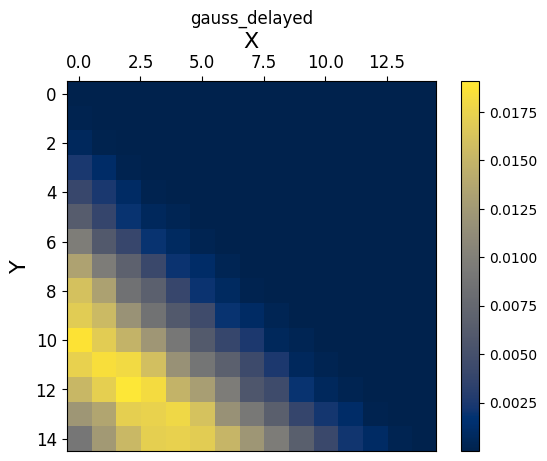

In [23]:
fig, ax = plt.subplots()
plt.imshow(infomat, cmap = 'cividis')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel('X', fontsize = 16)
plt.ylabel('Y', fontsize = 16)
ax.tick_params(axis = 'x', labelsize = 'large')  # Increase x-axis tick label size
ax.tick_params(axis = 'y', labelsize = 'large')  # Increase y-axis tick label size
plt.title(case)
plt.colorbar()
plt.show()